## Streaming

Methods: **`.stream()`** and **`stream()`**

-   These methods are sync and async methods for streaming back results.

Additional params in streaming modes for graph state

-   **`Values`**: This streams the full state of the graph after each nodes is called.
-   **`Updates`**: This streams updates to the state of the graph of the graph after each nodes is called.

# Implementing Simple ChatBot Using LangGraph with Streaming

In [9]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END

## Reducer
from typing import Annotated
from langgraph.graph.message import add_messages

In [10]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [11]:
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [12]:
from langchain_groq import ChatGroq

llm_groq = ChatGroq(model = "qwen/qwen3-32b")
llm_groq.invoke("Hey my name is Pawan, I like cricket")

AIMessage(content="<think>\nOkay, Pawan mentioned he likes cricket. I should start by acknowledging his name and interest. Maybe ask him about his favorite team or player to keep the conversation going. I can also offer to provide cricket-related information or tips if he needs it. Keep the tone friendly and open-ended. Let me check for any grammar issues and make sure the response is warm and engaging.\n</think>\n\nHi Pawan! Nice to meet you. 🏏 Cricket is an amazing sport—do you follow any particular team or player closely? I'd love to hear what you enjoy most about the game!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 121, 'prompt_tokens': 18, 'total_tokens': 139, 'completion_time': 0.267661435, 'prompt_time': 0.00060239, 'queue_time': 0.04537347, 'total_time': 0.268263825}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--81dd635a-16b7-4576-b95e

### Will Start crreating with Nodes.

In [13]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
config_1= {"configurable":{"thread_id":"Pawan"}}
def superbot(state:State):
    return {"messages":[llm_groq.invoke(state['messages'])]}

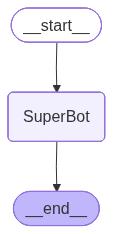

In [14]:
graph = StateGraph(State)

## node
graph.add_node("SuperBot",superbot)

## Edges
graph.add_edge(START , "SuperBot")
graph.add_edge("SuperBot",END)

graph_builder = graph.compile(checkpointer=memory)

## Display
from IPython.display import Image , display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [15]:
# Invocation
graph_builder.invoke({"messages":"Hi , My name is Pawan and i like Cricket."},config=config_1)

{'messages': [HumanMessage(content='Hi , My name is Pawan and i like Cricket.', additional_kwargs={}, response_metadata={}, id='761ad3f0-15f2-44bf-a79d-93a485328d8e'),
  AIMessage(content="<think>\nOkay, the user introduced himself as Pawan and mentioned he likes cricket. I should respond in a friendly and engaging way. Let me start by greeting him back and acknowledging his interest in cricket. Maybe ask him about his favorite team or player to keep the conversation going. I should also check if there's anything specific he wants to discuss related to cricket, like recent matches or tips for improving his game. Keeping it open-ended so he can choose the direction. Need to make sure the tone is positive and encouraging.\n</think>\n\nHi Pawan! Nice to meet you. Cricket is an amazing sport—thrilling to watch and play! 🏏 Do you have a favorite team or player? Also, are you following any exciting matches or tournaments lately? Let me know if you'd like to discuss strategies, recent games, 

### Streaming the Response with Stream Method

In [20]:
config_2= {"configurable":{"thread_id":"User_P"}}
for chunk in graph_builder.stream({"messages":"Hi , My name is Pawan and i like Cricket."},config=config_2,stream_mode='updates'):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='<think>\nOkay, the user is Pawan and he mentioned liking Cricket already. Now he\'s repeating the same message. Maybe he wants to emphasize his interest or there\'s a typo. Let me check the history.\n\nIn the previous messages, Pawan said "I like cratoon." The assistant thought it was a typo for cartoon but then Pawan clarified again about Cricket. Wait, no, actually, in the second message, the user said "I like cratoon," which the assistant interpreted as either cartoon or craton. Now Pawan is repeating his initial message again. \n\nSo maybe he\'s trying to correct himself or clarify. But the first message was "Hi, My name is Pawan and i like Cricket." Then he said "I like cratoon," which might have been a typo. Now he\'s repeating the first message. Perhaps he\'s just testing or there\'s a technical issue. Alternatively, he might have intended to say "cricket" both times. \n\nI should acknowledge his message, confirm his interest in cric

In [21]:
# When Updates is called , you see the newest message. Let try again with Updates again /
for chunk in graph_builder.stream({"messages":"I like cratoon."},config=config_2,stream_mode='updates'):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='<think>\nOkay, let\'s see. The user mentioned they like "cratoon" again. They\'ve said it twice now. The first time, I thought maybe it was a typo for "cartoon" or "craton". Now, they\'re saying it again.\n\nHmm, considering the previous interactions, they might be trying to clarify or confirm their preference. Maybe "cratoon" is the correct term they\'re using, but it\'s not a common word. Let me check if "cratoon" is a real word. A quick search shows it\'s not a standard English word. So, it\'s either a typo or a term specific to their context. \n\nThe user\'s name is Pawan, and he likes cricket. The previous messages show a consistent pattern of mentioning "cratoon" after introducing his interests. Maybe he\'s referring to a specific type of cartoon or a term in cricket? Wait, "cratoon" could be a mix of "cricket" and "cartoon". Maybe he\'s referring to animated cricket or something like that. \n\nAlternatively, maybe it\'s a typo. If it

- In above both **`updates`** only newest messages are called and displayed.
- Now will try with **`values`**

In [22]:
for chunk in graph_builder.stream({"messages":"I like cratoon."},config=config_2,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi , My name is Pawan and i like Cricket.', additional_kwargs={}, response_metadata={}, id='a71775e4-c0fd-444d-a727-f80e0c9a6fe1'), AIMessage(content='<think>\nOkay, the user introduced himself as Pawan and mentioned he likes cricket. I need to respond in a friendly and engaging way. Let me start by greeting him back and acknowledging his interest in cricket. Maybe ask a follow-up question to keep the conversation going. I should keep it simple and positive.\n</think>\n\nHi Pawan! Nice to meet you! 🏏 Cricket is an amazing sport—do you follow any particular team or player closely? Or are you more into playing it yourself?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 20, 'total_tokens': 122, 'completion_time': 0.222903032, 'prompt_time': 0.000713009, 'queue_time': 0.045840661, 'total_time': 0.223616041}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_de

## Final conclusion 

- In above when used **`values`** both previous conversation also appended along with current conversation , while in case of **`updates`**
only current conversation will be displayed with **`stream`**

## Streaming the response with `astream` Method

### What is .astream()?

- **`.astream()`** is the asynchronous streaming method of LLMs in LangChain.
    - It returns an async generator that yields partial outputs (chunks) as the model generates them.
    - This lets you process tokens in real time, instead of waiting for the full completion.
    - Think of it like a faucet dripping water (async for loop catches each drop), versus waiting until the whole bucket is filled.
## Why use .astream()?

- Real-time UX → show users tokens as they arrive (like ChatGPT typing effect).
- Async-friendly → works in frameworks like FastAPI, Django async, or asyncio tasks.
- Efficiency → start processing before generation ends (e.g., streaming into a DB, summarizing live).

## What `.astream_events()` is ?

- Returns an async generator of event dictionaries.
- Each event tells you:
    - what happened (e.g., new token, LLM start, LLM end, tool call, chain step, error).
        where it happened (node/step in a graph, tool name, etc.).
- payload (e.g., token string, tool input/output).
- This is like getting debug + streaming output together in real time.
## Why use .astream_events() instead of .astream()
- .astream() → only gives LLM output chunks.
- .astream_events() → gives all events in the lifecycle:
- Start of generation
    - Each token
    - Tool invocations (agents)
    - End of generation
    - Errors

In [43]:
config_3 = {"configurable":{"thread_id":"3"}}
async for event in graph_builder.astream_events({"messages":["Hi my name is Pawan and i like cricket"]},config=config_3,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi my name is Pawan and i like cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '699ab364-8e6f-4652-b861-38711c95b7af', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is Pawan and i like cricket', additional_kwargs={}, response_metadata={}, id='e9829109-5536-4836-af0d-05c5fa8b7a8d'), AIMessage(content="<think>\nOkay, the user is Pawan and he mentioned he likes cricket. Let me start by greeting him and acknowledging his interest. I should ask him what specifically he wants to discuss about cricket. Maybe he wants to talk about his favorite teams, players, or recent matches. I should keep the response friendly and open-ended to encourage him to share more. Also, I need to make sure the tone is positive and engaging. Let me check if there are any recent cricket events I should reference, but since I don't have real-time data, I